## ML project 2

### Notes

- train model for each expert
- 0.5 'missing gender' somehing else than male/ female
- model ohne metadata wie age gender etc, just the coughs
- person coughs --> want to tell wether wet or dry
- dont use other expert information

Features:

- Columns C-BQ: Computed features in the time and frequency domain
- Column BR: The expert that reviwed the cough
- Columns BS-BV: Metadata features provided by users
    - Some values were not provided by users and were set to average values for each feature
- The 'SNR' feature exists for non-segmented coughs but not segmented coughs

MISC:

- Deal with missing metadata appropriately

- Perform exploratory data analysis and feature engineering (ex. examine theeffects of normalizing features, recursive feature elimination)

- Make sure that data from a single subject does not end up in both thetraining and validation groups

Cross validation:

- Compare the success of different classifiers, very carefully performing afair model comparison (i.e. relying on validation scores using leave-n-subjects-out cross-validation).

Model Comparison:


- Compare classification success on segmented and non-segmented coughrecordings (all pre-processing will be done by the lab)
- Tune the model hyperparameters appropriately

- Assess the importance of different features to the classification result by analyzing the weights of the classifier or SHAP values.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import IPython.display
import matplotlib.pyplot as plt
import importlib
import src.utils
from src.utils.preprocessing import import_data, standardize, dummy_code, oversample, remove_correlated_features
from src.utils.model_helpers import roc_w_cross_val, AUC_all_models, homemade_all_models
from src.utils.model.train import cross_validation, cross_validation_iter, train_test_split
from src.utils.feature_engineering import RFE_, train_optimal_features_model

In [2]:
# Preprocessing
from imblearn.over_sampling import SMOTE
# ML models
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [17]:
# to reload modules
importlib.reload(src.utils.preprocessing)
importlib.reload(src.utils.model.train)
importlib.reload(src.utils.model_helpers)
#importlib.reload(src.utils.feature_engineering)


<module 'src.utils.model_helpers' from '/home/mogan/Dropbox/Semester_1_EPFL/ML_Project/Project2/cs-433-project-2-cough_classifier/src/utils/model_helpers.py'>

In [4]:
# dir(src.utils.preprocessing)

In [5]:
DATA_PATH = '../../data'

## Load Data

In [6]:
# Load data
# Labels: # 1 - Wet Cough # 0 - Dry Cough
coarse_data, coarse_labels = import_data(DATA_PATH, segmentation_type = 'coarse', is_user_features=True)
fine_data, fine_labels = import_data(DATA_PATH, segmentation_type = 'fine', is_user_features=True)
no_data, no_labels = import_data(DATA_PATH, segmentation_type = 'no', is_user_features=True)

# For later processing rename the index
no_data.index = no_data.index.rename('subject')
#display(coarse_data.head(2), fine_data.head(2), no_data.head(2))
#display(coarse_labels.head(2), fine_labels.head(2), no_labels.head(2))

In [7]:
# if no preprocessing is desired
X_coarse = coarse_data
X_fine = fine_data
X_no = no_data

## EDA

In [ ]:
# Xavi?

## Data Preprocessing

### Normalisation

In [8]:
# For case where is_user_features=True
X_coarse = standardize(X_coarse, 0,-3)
X_fine = standardize(X_fine, 0,-3)
X_no = standardize(X_no, 0,-3)

### Inspect Missing Data

### Dummy code categorical features

In [9]:
X_coarse = dummy_code(X_coarse, columns = ['Gender', 'Resp_Condition', 'Symptoms'])
X_fine = dummy_code(X_fine, columns = ['Gender', 'Resp_Condition', 'Symptoms'])
X_no = dummy_code(X_no, columns = ['Gender', 'Resp_Condition', 'Symptoms'])

### Train and Test data

In [23]:
#no_data_X_tr, no_labels_y_tr, no_data_X_te,  no_labels_y_te = train_test_split(X_no, no_labels)
#coarse_data_X_tr, coarse_labels_y_tr, coarse_data_X_te, coarse_labels_y_te = train_test_split(X_coarse, coarse_labels)
#fine_data_X_tr, fine_labels_y_tr, fine_data_X_te, fine_labels_y_te = train_test_split(X_fine, fine_labels)

### Class imbalance

In [89]:
print("Proportion of positive labels:", "\n", np.round(no_labels['Label'].sum() / no_labels['Label'].shape[0],4), 
                                              np.round(coarse_labels['Label'].sum() / coarse_labels['Label'].shape[0],4),
      np.round(fine_labels['Label'].sum() / fine_labels['Label'].shape[0],4))

Proportion of positive labels: 
 0.5 0.5 0.5


#### Has to be applied after splitting train and test set, since it annulates multilevel indexes

In [18]:
# Do something about it: SMOTE
X_coarse, coarse_labels = oversample(X_coarse, coarse_labels)
X_fine, fine_labels = oversample(X_fine, fine_labels)
X_no, no_labels = oversample(X_no, no_labels)

## Feature Engineering

### Feature Selection

#### Drop correlated features

In [10]:
# Drop features with a Pearson correlation > 0.9 to prevent multicollinearity
X_no = remove_correlated_features(X_no, 0.95)
X_coarse = remove_correlated_features(X_coarse, 0.95)
X_fine = remove_correlated_features(X_fine, 0.95)

### Find interesting features

#### Recursive Feature Elimination

>40 0.749 (0.029)
>41 0.748 (0.029)
>42 0.748 (0.028)
>43 0.747 (0.028)
>44 0.747 (0.028)
>45 0.747 (0.028)
>46 0.747 (0.028)
>47 0.746 (0.028)
>48 0.746 (0.028)
>49 0.746 (0.028)
>50 0.746 (0.028)
>51 0.746 (0.028)
>52 0.746 (0.028)
>53 0.746 (0.028)
>54 0.746 (0.028)


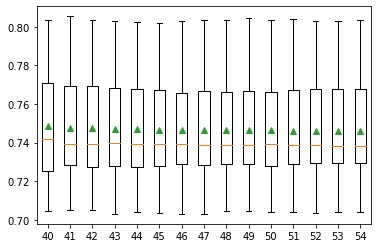

In [21]:
RFE_no_results = RFE_(LogisticRegression(), X_no, no_labels.Label)

>1 0.555 (0.031)
>2 0.617 (0.035)
>3 0.641 (0.029)
>4 0.651 (0.029)
>5 0.667 (0.030)
>6 0.688 (0.031)
>7 0.709 (0.032)
>8 0.723 (0.030)
>9 0.726 (0.029)
>10 0.727 (0.030)
>11 0.728 (0.030)
>12 0.729 (0.030)
>13 0.730 (0.030)
>14 0.730 (0.031)
>15 0.731 (0.030)
>16 0.730 (0.029)
>17 0.730 (0.029)
>18 0.731 (0.028)
>19 0.733 (0.029)
>20 0.734 (0.028)
>21 0.735 (0.027)
>22 0.736 (0.028)
>23 0.736 (0.028)
>24 0.738 (0.028)
>25 0.741 (0.027)
>26 0.741 (0.027)
>27 0.744 (0.027)
>28 0.745 (0.027)
>29 0.745 (0.027)
>30 0.746 (0.028)
>31 0.746 (0.028)
>32 0.746 (0.029)
>33 0.746 (0.028)
>34 0.747 (0.029)
>35 0.747 (0.029)
>36 0.748 (0.030)
>37 0.749 (0.029)
>38 0.749 (0.029)
>39 0.749 (0.029)
>40 0.749 (0.029)
>41 0.748 (0.029)
>42 0.748 (0.028)
>43 0.747 (0.028)
>44 0.747 (0.028)
>45 0.747 (0.028)
>46 0.747 (0.028)
>47 0.746 (0.028)
>48 0.746 (0.028)
>49 0.746 (0.028)
>50 0.746 (0.028)
>51 0.746 (0.028)
>52 0.746 (0.028)
>53 0.746 (0.028)
>54 0.746 (0.028)


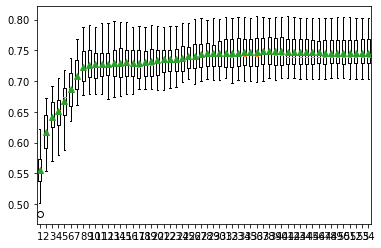

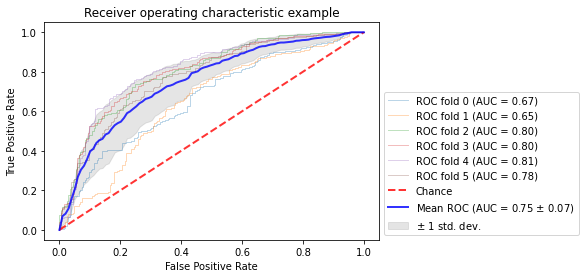

0.7513378645372906

In [48]:
train_optimal_features_model(X_no, no_labels.Label, LogisticRegression())

###  Polynomial Feature Expansion

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

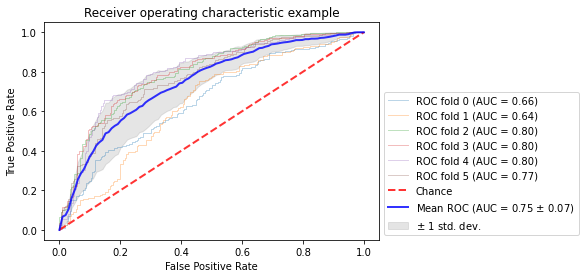

/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

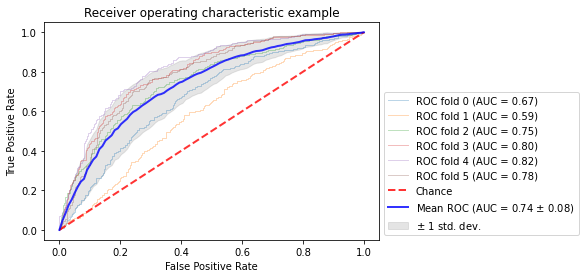

/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

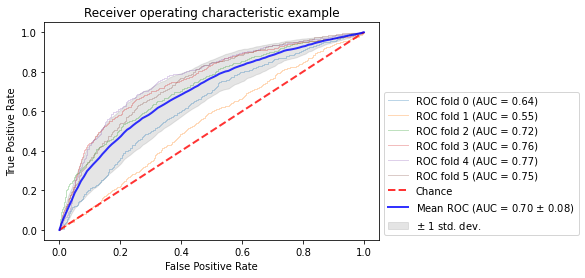

0.6975756839249388

In [20]:
# Inspect effects for log regression
roc_w_cross_val(X_no, no_labels.Label, LogisticRegression())
roc_w_cross_val(X_coarse, coarse_labels.Label, LogisticRegression())
roc_w_cross_val(X_fine, fine_labels.Label, LogisticRegression())

## Methoden

/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

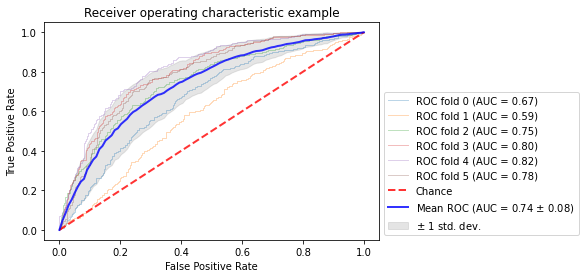

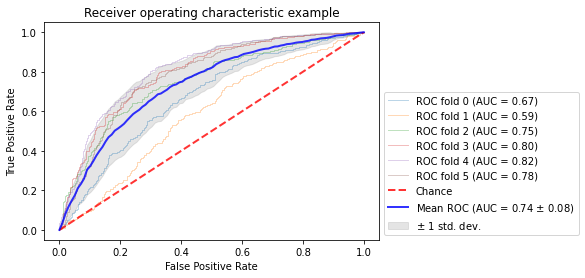

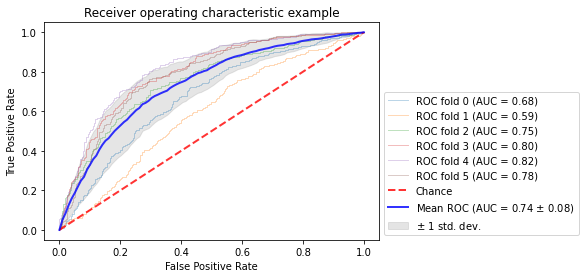

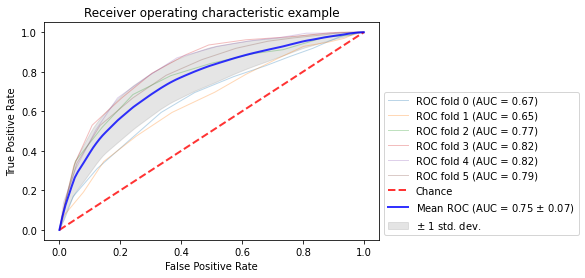

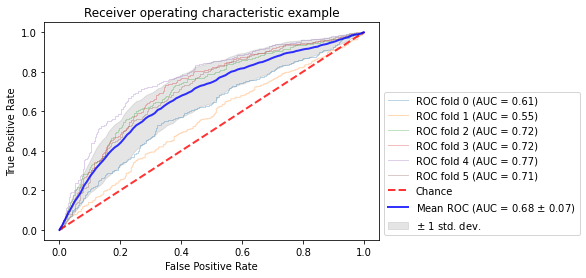

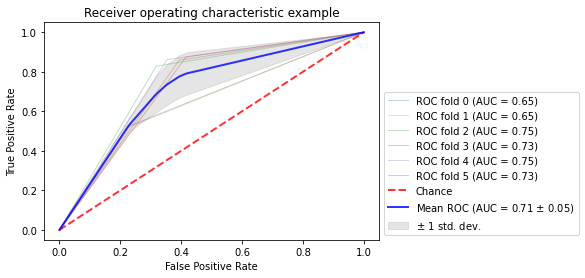

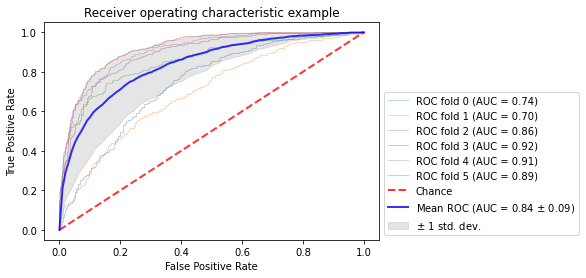

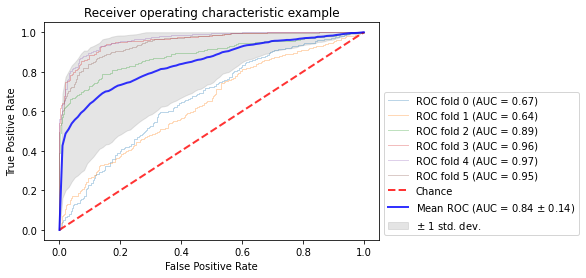

/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

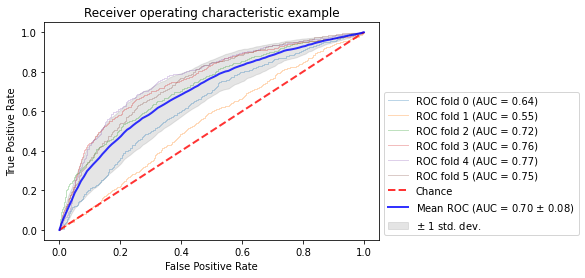

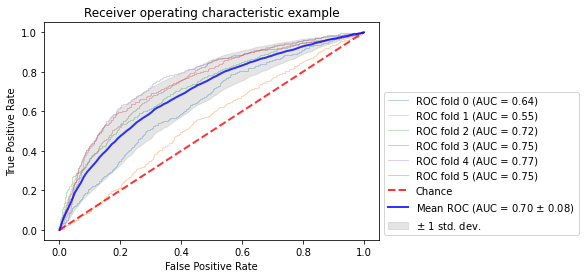

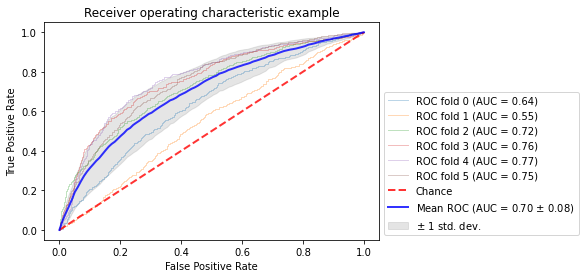

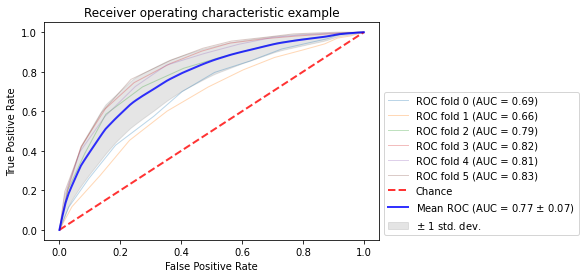

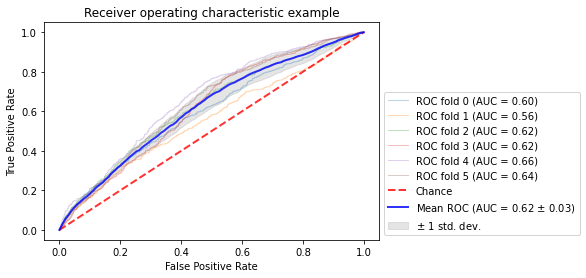

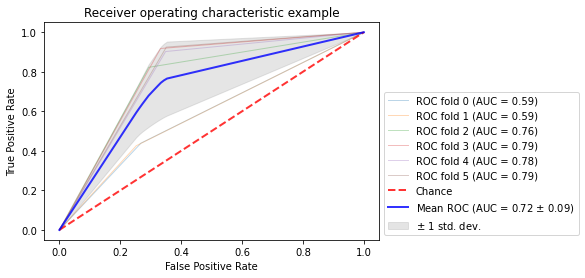

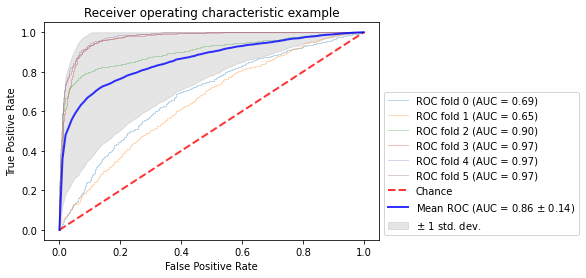

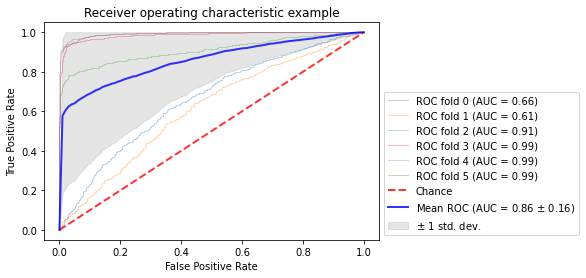

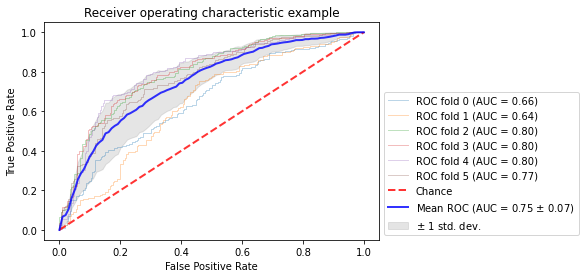

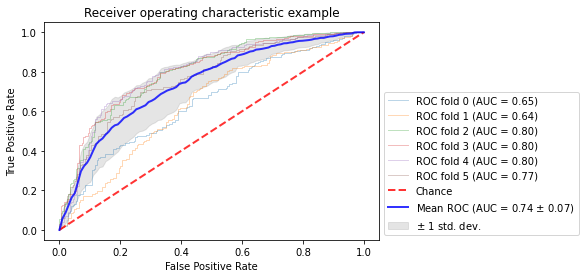

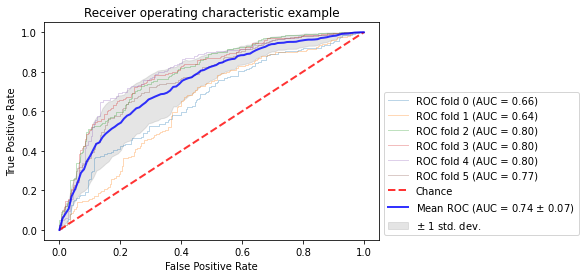

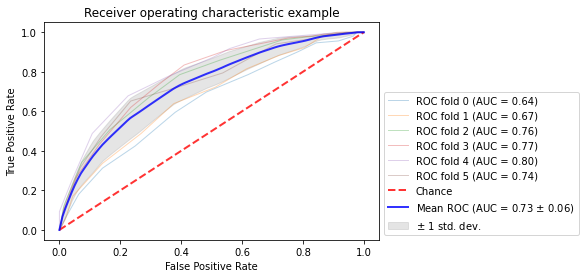

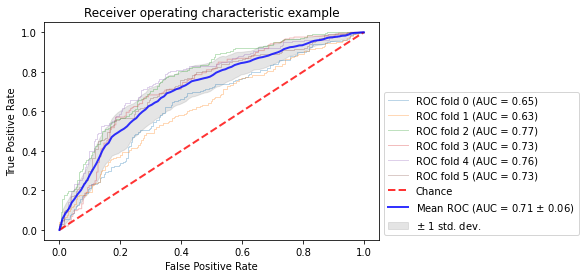

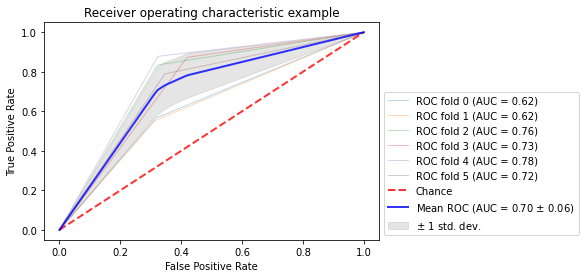

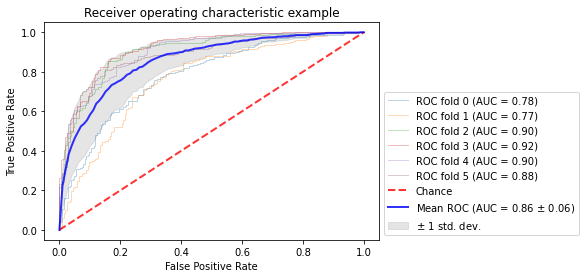

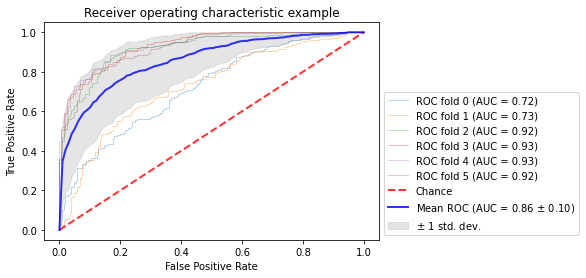

In [35]:
coarse_results = AUC_all_models(X_coarse, coarse_labels.Label)
fine_results = AUC_all_models(X_fine, fine_labels.Label)
no_results = AUC_all_models(X_no, no_labels.Label)


#### Inspect results

In [49]:
pd.concat([coarse_results, fine_results['AUC (mean)'], no_results['AUC (mean)']], axis=1, sort=False)

,Models,AUC (mean),AUC (mean),AUC (mean)
0,LogisticRegression,0.736348,0.697576,0.745543
1,SVM,0.735149,0.696925,0.742624
2,LDA,0.737244,0.697807,0.744589
3,KNN,0.753559,0.768130,0.731747
4,GaussianNB,0.679186,0.616945,0.710830
5,DecisionTree,0.711004,0.715493,0.704241
6,RandomForest,0.836946,0.858616,0.859473
7,GradientBoosting,0.842759,0.856607,0.858197


### Logistic regression

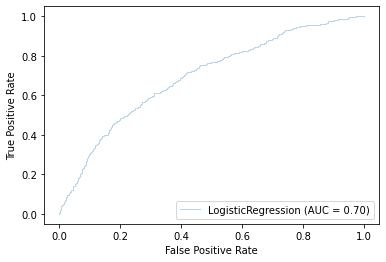

In [60]:
logistic = LogisticRegression()
logistic.fit(X_no, no_labels.Label)

fig, ax = plt.subplots()
plot_roc_curve(logistic, X_no, no_labels,
                         alpha=0.3, lw=1, ax=ax)

plt.show()

In [55]:
cross_validation(X_no, no_labels.Label, 5, LogisticRegression(), metric=roc_auc_score)

0.5241780185800045

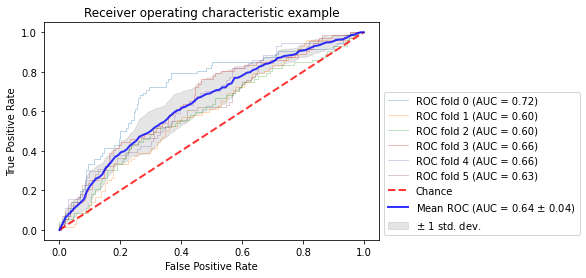

0.6425410863986764

In [59]:
roc_w_cross_val(X_no, no_labels.Label, LogisticRegression())

In [40]:
homemade_all_models(X_no, no_labels.Label, 5) #AUC 62

,models,AUC (mean)
0,LogisticRegression,0.524648
1,SVM,0.500000
2,LDA,0.527867
3,KNN,0.526875
4,GaussianNB,0.561609
5,DecisionTree,0.516939
6,RandomForest,0.502588
7,GradientBoosting,0.511983


### k Nearest Neighbour

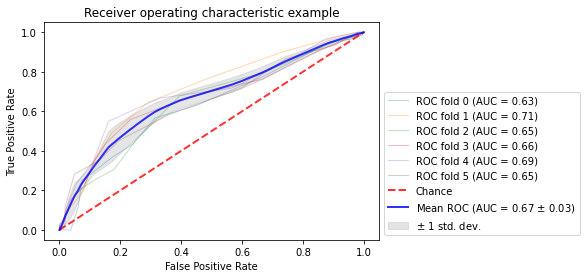

In [49]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, KNeighborsClassifier(n_neighbors=16))

### Gaussian Naive Bayes

In [32]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, GaussianNB())

NameError: name 'no_data_X_tr' is not defined

### Decision Tree

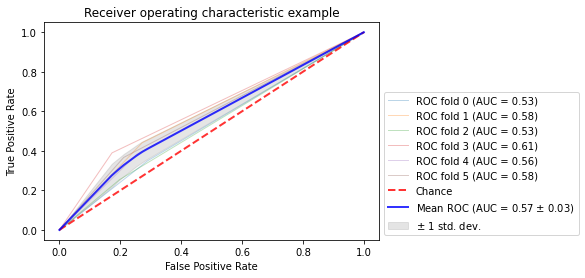

In [73]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, DecisionTreeClassifier(random_state=0))

### RandomForest

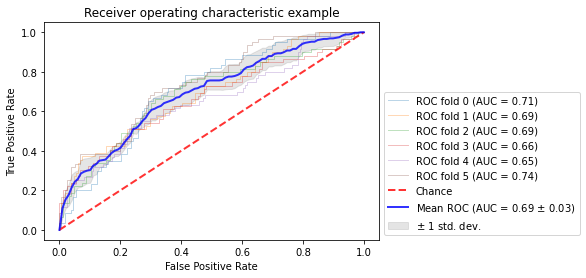

In [78]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, RandomForestClassifier(max_depth=7, random_state=0))

### eXtreme Gradient Boosting

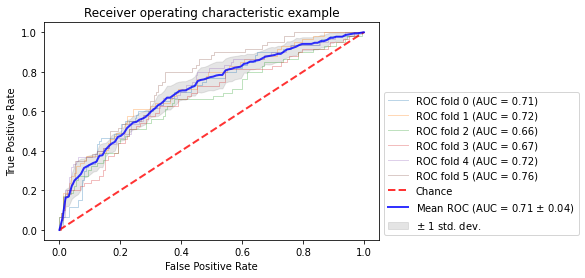

In [79]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, GradientBoostingClassifier(random_state=0))